## <font color='green'>Setup 1</font>: Load Libraries

In [1]:
import sys
root_dir = "../"
sys.path.append(root_dir)

from test_bad_word import *
from utility import *

import time
import numpy as np
import pandas as pd
#pd.options.display.max_columns = None
#pd.options.display.mpl_style = 'default'
import tensorflow as tf

import re
import os
import sys
import random
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import sparse

from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
    
stemmer = SnowballStemmer('english')

## <font color='green'>Setup 2</font>: Load Datasets

In [2]:
bad_word_1  = [line.rstrip('\n') for line in open('../wordlist/google_bad_word.txt')]
#bad_word_2  = [line.rstrip('\n') for line in open('handcrafted_badword.txt')]
bad_word= set(bad_word_1  + test_bad_word)

strong_pos  = [line.rstrip('\n') for line in open('../wordlist/strong_pos.txt')]
strong_neg  = [line.rstrip('\n') for line in open('../wordlist/strong_neg.txt')]
weak_pos  = [line.rstrip('\n') for line in open('../wordlist/weak_pos.txt')]
weak_neg  = [line.rstrip('\n') for line in open('../wordlist/weak_neg.txt')]

In [3]:
df_train = pd.read_csv('data/RNN_train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('data/RNN_test.csv', encoding="ISO-8859-1")
df_val = pd.read_csv('data/RNN_val.csv', encoding="ISO-8859-1")

num_train = df_train.shape[0]
num_test = df_test.shape[0]
num_val = df_val.shape[0]

In [4]:
def data_transform(file):
    data = []
    length = len(file)
    sentences = file['Comment constructed'].values
    insults = file['Insult'].values
    for i in range(length):
        current_sentences = sentences[i]
        current_insult = insults[i]
        instance = {"sentences": eval(current_sentences), "insult": current_insult}
        data.append(instance)
    return data

train = data_transform(df_train)
test = data_transform(df_test)
val = data_transform(df_val)

## <font color='green'>Setup 3</font>: Pipeline Datasets

* comment length: number of setences in a comment
* sentence length: number of words in a sentene

In [5]:
glove_size = 100


word_vector_list = []

#file= open('word2vec/glove.6B.%sd.txt' % glove_size, 'r', encoding='utf-8')
#file= open('word2vec/glove.840B.300d.txt', 'r', encoding='utf-8')
file= open('word2vec/glove.twitter.27B.%sd.txt' % glove_size, 'r', encoding='utf-8')
for line in file:
    line = line.rstrip().split(' ')
    word_vector_list.append(line[0])

In [6]:
max_comment_len = 15
max_sentence_len = 25

In [7]:
def pipeline(data, vocab = None, max_comment_len = 17, max_sentence_len_ = None):
    if vocab is None:
        vocab = {'<PAD>': 0, '<OOV>': 1}

    max_sentence_len = -1
    data_sentences = []
    data_insults = []
    for instance in data:
        sents = []
        for sentence_id, sentence in enumerate(instance['sentences']):
            if sentence_id <= max_comment_len:
                sent = []
                tokenized = sentence.split(' ')
                for token in tokenized:
                    token = token.lower()
                    if token not in word_vector_list:
                        token_id = vocab['<OOV>']
                    elif token in word_vector_list and token not in vocab:
                        vocab[token] = len(vocab)
                        token_id = vocab[token]
                    else:
                        token_id = vocab[token]
                    sent.append(token_id)
                if len(sent) > max_sentence_len:
                    max_sentence_len = len(sent)
                sents.append(sent)
        data_sentences.append(sents)
        data_insults.append(instance['insult'])
        
    if max_sentence_len_ is not None:
        max_sentence_len = max_sentence_len_
    out_sentences = np.full([len(data_sentences), max_comment_len, max_sentence_len], vocab['<PAD>'], dtype=np.int32)

    for i, elem in enumerate(data_sentences):
        for j, sent in enumerate(elem):
            if j < max_comment_len:
                if len(sent) <= max_sentence_len:
                    out_sentences[i, j, 0:len(sent)] = sent
                else:
                    out_sentences[i, j, 0: max_sentence_len] = sent[:max_sentence_len]

    return out_sentences, np.array(data_insults), vocab

In [8]:
t_0 = time.time()

train_sentences, train_insults, vocab = pipeline(train, max_comment_len = max_comment_len, max_sentence_len_ = max_sentence_len)
test_sentences, test_insults, vocab = pipeline(test, vocab, max_comment_len, max_sentence_len)

print('time: ',time.time() - t_0)

time:  181.36499905586243


In [48]:
train_sentences.shape, test_sentences.shape,

((3947, 15, 25), (2647, 15, 25))

In [49]:
def sentence_length_filler(sentence_length, max_comment_len):
    n = sentence_length.shape[0]
    out_array = np.full([n, max_comment_len], 0, dtype=np.int32)
    for i,sen_len in enumerate(sentence_length):
        sen_len = eval(sen_len)
        out_array[i,0:len(sen_len)] = sen_len[:max_comment_len]
    return out_array

In [50]:
# need a fill-in function here 

train_comment_length = df_train['comment length'].values
train_sentences_length = df_train['sentences length'].values
train_sentences_length = sentence_length_filler(train_sentences_length, max_comment_len)

test_comment_length = df_test['comment length'].values
test_sentences_length = df_test['sentences length'].values
test_sentences_length = sentence_length_filler(test_sentences_length, max_comment_len)

In [51]:
train_comment_length.shape

(3947,)

## <font color='green'>Setup 4</font>: Word2Vec

In [52]:
import collections
import operator

glove_size = 100

word_dict= collections.defaultdict(list)
vocab_keys = vocab.keys()

#file= open('word2vec/glove.6B.%sd.txt' % glove_size, 'r', encoding='utf-8')
file= open('word2vec/glove.twitter.27B.%sd.txt' % glove_size, 'r', encoding='utf-8')
#file= open('word2vec/glove.840B.300d.txt', 'r', encoding='utf-8')
for line in file:
    line = line.rstrip().split(' ')
    if line[0] in vocab_keys:
        word_dict[line[0]]=[float(i) for i in line[1:]]
    
word_dict=dict(word_dict)

In [53]:
sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1))

embedding_list=[]
#OOV_vector = [random.uniform(-1, 1) for i in range(glove_size)]
OOV_vector  = np.mean(list(word_dict.values()),axis=0)

for item in sorted_vocab:
    if item[0]== '<PAD>':
        embedding_list.append(np.array([0 for i in range(glove_size)], dtype='f'))
    elif item[0] =='_cr_':
        embedding_list.append(word_dict['fuck'])
    elif item[0] in word_dict:
        embedding_list.append(word_dict[item[0]])
    else:
        if item[0] in bad_word:
            embedding_list.append(word_dict['fuck']) 
        else:
            embedding_list.append(OOV_vector)
        #embedding_list.append('unseen')
       
W = np.array(embedding_list)
#print("unseen ratio:", embedding_list.count('unseen')/len(vocab))

In [54]:
normal_index = df_train[df_train['Insult']==0].index.tolist()
insult_index = df_train[df_train['Insult']==1].index.tolist()

In [55]:
W.shape

(16477, 100)

## <font color='green'>Setup 5</font>: Construct RNN:

### tricks which have positive effect:
* pre-trained word2vec (✓,  trainable: False > True for better generalisation)
* different max sentence/comment length ( max_comment_len: 17-->5 & max_sent_len: 50-->25 ✓)
* recheck the pipeline (lowercase tansformation ✓)

### tricks which have no obvious effect:
* regularisation: dropout/L2 
* weighted loss (insignificant)
* sentence/paragraph pooling: mean pooling

### tricks which have negative effect : 
* attention on sentence/word (×)
* downsampling mini batch training (×)

### to do list:
* self trained word2vec ?

In [57]:
### MODEL PARAMETERS ###

max_comment_len = train_sentences.shape[1]
max_sen_len = train_sentences.shape[2]
vocab_size = len(vocab)
word2vec_size = glove_size
sentence_hidden_size = 100
comment_hidden_size = 100
target_size = 2
dropout_rate = 0.8

In [58]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [59]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.InteractiveSession()

sentences = tf.placeholder(tf.int64, [None, None, None], "sentences")                # [batch_size x max_comment_len x max_sen_len]
sentences_length = tf.placeholder(tf.int64, [None, None], "sentences_length")        # [batch_size x max_comment_len]
comment_length = tf.placeholder(tf.int64, [None], "comment_length")                  # [batch_size]
insult = tf.placeholder(tf.int64, [None], "insult")                              # [batch_size x 1]

batch_size = tf.shape(sentences)[0]

# max_comment_len x [batch_size x max_sen_len]
sentences_lst = [tf.reshape(x, [batch_size, -1]) for x in tf.split(sentences, max_comment_len, 1)] 
sentences_length_lst = [tf.reshape(x,[-1]) for x in tf.split(sentences_length, max_comment_len, 1)] 

initializer = tf.random_uniform_initializer(-0.1, 0.1)
embeddings = tf.get_variable("W", [vocab_size, word2vec_size], initializer=initializer, trainable= True)
embeddings = embeddings.assign(W) 

# max_comment_len x [batch_size x max_sen_len x word2vec_size]
sentences_embedded = [tf.nn.embedding_lookup(embeddings, sentence)  
                          for sentence in sentences_lst] 

# split sentences_embedded into n parts, name as sentence0, sentence1, etc
for i in range(max_comment_len):
    globals()['sentences_embedded_%s' % i] = sentences_embedded[i]     # [batch_size x max_sen_len x word2vec_size]
    globals()['sentences_length_%s' % i] = sentences_length_lst[i]   


### ------------------------------------------------------------------------------------------------------- ### 
### ---------------------------------------- sentence encoders -------------------------------------------  ###
### ------------------------------------------------------------------------------------------------------- ### 

lstm_sentence_cell = tf.contrib.rnn.LSTMCell(sentence_hidden_size, state_is_tuple= True)
#lstm_sentence_cell = tf.contrib.rnn.DropoutWrapper(lstm_sentence_cell, dropout_rate, dropout_rate)
with tf.variable_scope("sentence_encoder") as varscope: 
    _, sentence_0_final_state = tf.nn.dynamic_rnn(lstm_sentence_cell, sentences_embedded_0,\
                                                  sequence_length = sentences_length_0, dtype=tf.float32)        
    sentence_0 = sentence_0_final_state.h  

    for i in range(1, max_comment_len):
        varscope.reuse_variables()
        _, globals()['sentence_%s_final_state' % i] = tf.nn.dynamic_rnn(lstm_sentence_cell, globals()['sentences_embedded_%s' % i],\
                                                    sequence_length = globals()['sentences_length_%s' % i], dtype=tf.float32)        
        globals()['sentence_%s' % i] = globals()['sentence_%s_final_state' % i].h

#[batch_size x max_comment_len x sentence2vec_size]
sentence_vectors = tf.stack([globals()['sentence_%s' % i]  for i in range(max_comment_len)], axis=1)

### ------------------------------------------------------------------------------------------------------- ### 
### ---------------------------------------- comment encoders --------------------------------------------  ###
### ------------------------------------------------------------------------------------------------------- ### 

lstm_comment_cell = tf.contrib.rnn.LSTMCell(comment_hidden_size, state_is_tuple= True)
#lstm_comment_cell = tf.contrib.rnn.DropoutWrapper(lstm_comment_cell, dropout_rate, dropout_rate)
with tf.variable_scope("comment_encoder") as varscope: 
    comment_all_state, comment_final_state = tf.nn.dynamic_rnn(lstm_comment_cell, sentence_vectors,\
                                               sequence_length = comment_length, dtype=tf.float32)        
    comment_vectors = comment_final_state.h
'''
def sentence_attention(sentence,w_1,w_2, sentence_attention_size):
    s_1=tf.tanh(tf.cast(tf.reshape(tf.matmul(tf.reshape(sentence,[-1,comment_hidden_size]),w_1),\
                                   [-1,max_comment_len,sentence_attention_size]),dtype=tf.float32))
    print(s_1)
    s_2=tf.stack([tf.nn.softmax(tf.reduce_sum(s_1*w_2,-1))],2)
    print(s_2)
    return tf.reduce_sum(sentence*s_2,1)   

w_3 = tf.Variable(tf.random_normal([comment_hidden_size,100]))
w_4 = tf.Variable(tf.random_normal([100]))  

comment_vectors = sentence_attention(comment_all_state, w_3, w_4,  100)    
 '''

#comment_vectors = tf.div(tf.reduce_sum(comment_all_state, 2), tf.stack([tf.cast(comment_length, tf.float32)],1))    

### ------------------------------------------------------------------------------------------------------- ### 
### ---------------------------------------- loss & prediction -------------------------------------------  ###
### ------------------------------------------------------------------------------------------------------- ###     

#h = tf.nn.dropout(tf.contrib.layers.linear(comment_vectors, 100),0.8) 
h = tf.contrib.layers.linear(comment_vectors, 100)
logits = tf.contrib.layers.linear(h, target_size)
probability = tf.nn.softmax(logits)
predict = tf.argmax(probability, axis=1)

L2 = tf.add_n([ tf.nn.l2_loss(v) for v in tf.trainable_variables()]) 

loss = tf.reduce_sum(tf.losses.sparse_softmax_cross_entropy(logits = logits, labels = insult, weights = insult*2 + 1 ))
                                                                                          ### weights = insult*2 + 1
'''
logits = tf.contrib.layers.fully_connected(comment_vectors, 1)
labels = tf.cast(tf.stack([insult], axis=1), tf.float32)
loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))    
probability = tf.sigmoid(logits)   
predict = tf.argmax(probability, axis=1)
'''

opt_op = tf.train.AdamOptimizer(0.005).minimize(loss)

print('graph created')

graph created


In [60]:
BATCH_SIZE = 100
split_num = 50
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n = train_sentences.shape[0]
    print('hyperparameters: ', 'max_comment_len=', max_comment_len, ', max_sentence_len=', max_sentence_len, \
          ', sentence_hidden_size=',sentence_hidden_size, ', comment_hidden_size=', comment_hidden_size , \
          ', word2vec_size=', word2vec_size)

    train_sentences_splited = list(split(train_sentences, split_num))
    train_insults_splited = list(split(train_insults, split_num))
    train_comment_length_splited = list(split(train_comment_length, split_num))
    train_sentences_length_splited = list(split(train_sentences_length, split_num))
    test_sentences_splited = list(split(test_sentences, split_num))
    test_insults_splited = list(split(test_insults, split_num))
    test_comment_length_splited = list(split(test_comment_length, split_num))
    test_sentences_length_splited = list(split(test_sentences_length, split_num))        

    for epoch in range(15):
        print('----- Epoch', epoch + 1, '-----')
        total_loss = 0
        t_0 = time.time()
        
        for i in range(n // BATCH_SIZE):
            index_list = random.sample(range(n), BATCH_SIZE )
            inst_train_sentences = [train_sentences[idx] for idx in index_list]
            inst_train_insults = [train_insults[idx] for idx in index_list]
            inst_train_comment_length = [train_comment_length[idx] for idx in index_list]
            inst_train_sentences_length = [train_sentences_length[idx] for idx in index_list]

            feed_dict = {sentences: inst_train_sentences, insult:inst_train_insults,\
                   comment_length: inst_train_comment_length, sentences_length: inst_train_sentences_length}
            _, current_loss = sess.run([opt_op, loss], feed_dict=feed_dict)
            total_loss += current_loss

        print(' Train loss:', total_loss / n, 'Time:', round((time.time()-t_0)/60,2),'minute') 

        train_predicted = []
        train_probability = []
        for i in range(split_num):
            train_feed_dict = {sentences: train_sentences_splited[i], insult: train_insults_splited[i],\
                               comment_length: train_comment_length_splited[i], sentences_length: train_sentences_length_splited[i]} 
            train_current_predicted, train_current_probability = sess.run([predict,probability], feed_dict=train_feed_dict)
            train_predicted = train_predicted + list(train_current_predicted)
            train_probability = train_probability + list(train_current_probability)

        train_f1 = f1_score(train_insults, train_predicted)
        train_auc = roc_auc_score(train_insults, np.array(train_probability)[:,1])
        print(' Train F1:', train_f1,' Train AUC:', train_auc)   

        test_predicted = []
        test_probability = []
        for i in range(split_num):
            test_feed_dict = {sentences: test_sentences_splited[i], insult: test_insults_splited[i],\
                               comment_length: test_comment_length_splited[i], sentences_length: test_sentences_length_splited[i]} 
            test_current_predicted, test_current_probability = sess.run([predict,probability], feed_dict=test_feed_dict)
            test_predicted = test_predicted + list(test_current_predicted)
            test_probability = test_probability + list(test_current_probability)

        test_f1 = f1_score(test_insults, test_predicted)
        test_auc = roc_auc_score(test_insults, np.array(test_probability)[:,1])
        print(' Dev F1:', test_f1,' Dev AUC:', test_auc)
        print(confusion_matrix(test_insults, test_predicted))
        
        W = sess.run(embeddings)

hyperparameters:  max_comment_len= 15 , max_sentence_len= 25 , sentence_hidden_size= 100 , comment_hidden_size= 100 , word2vec_size= 100
----- Epoch 1 -----
 Train loss: 0.0077561002186 Time: 0.36 minute
 Train F1: 0.709519136408  Train AUC: 0.882667511403
 Dev F1: 0.676646706587  Dev AUC: 0.861728854564
[[1763  191]
 [ 241  452]]
----- Epoch 2 -----
 Train loss: 0.00605401112093 Time: 0.34 minute
 Train F1: 0.769094922737  Train AUC: 0.929652348913
 Dev F1: 0.702484889187  Dev AUC: 0.895044168842
[[1681  273]
 [ 170  523]]
----- Epoch 3 -----
 Train loss: 0.00491269565184 Time: 0.34 minute
 Train F1: 0.812993854258  Train AUC: 0.954118780185
 Dev F1: 0.723517654897  Dev AUC: 0.899374280899
[[1689  265]
 [ 150  543]]
----- Epoch 4 -----
 Train loss: 0.00399285655309 Time: 0.38 minute
 Train F1: 0.85288966725  Train AUC: 0.97174376859
 Dev F1: 0.724367509987  Dev AUC: 0.904168162101
[[1689  265]
 [ 149  544]]
----- Epoch 5 -----
 Train loss: 0.00307712060441 Time: 0.39 minute
 Train F1:

KeyboardInterrupt: 

In [ ]:
def plot_confusion_matrix_dict(matrix,rotation=45, outside_label=""):
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(0)
    plt.xticks(tick_marks, [0,1], rotation=rotation)
    plt.yticks(tick_marks, [0,1])
    
cm=confusion_matrix(test_insults, test_predicted)
print(cm)
plot_confusion_matrix_dict(cm)

In [ ]:
print(predict_analysis(test_insults, test_predicted, np.array(test_probability)[:,1], 'fp', df_test)[50])
print('')
print(predict_analysis(test_insults, test_predicted, np.array(test_probability)[:,1], 'fn', df_test)[10])
print('')
print(predict_analysis(test_insults, test_predicted, np.array(test_probability)[:,1], 'tp', df_test)[50])

In [ ]:
print(predict_analysis(test_insults, test_predicted, np.array(test_probability)[:,1], 'fp', df_test)[50])
print('')
print(predict_analysis(test_insults, test_predicted, np.array(test_probability)[:,1], 'fn', df_test)[10])
print('')
print(predict_analysis(test_insults, test_predicted, np.array(test_probability)[:,1], 'tp', df_test)[50])

* word2vec visualisation

In [61]:
cursing_index = []
cursing_word = []
word_label = []

for word_tuple in sorted_vocab:
    word_label.append(word_tuple[0])
    if word_tuple[0] in bad_word:
        cursing_index.append(word_tuple[1])
        cursing_word.append(word_tuple[0])

In [71]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline


def _plot_with_labels(low_dim_embs, labels, path, size):
    import matplotlib.pyplot as plt
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    figure = plt.figure(figsize=size)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        if label in bad_word:
            color = 'red'
        elif label in strong_neg:
            color = 'orange'
        elif label in weak_neg:
            color = 'orange'
        elif label in weak_pos:
            color = 'green'
        elif label in strong_pos:
            color = 'green'
        else:
            color = 'black'
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right',
                     va='bottom', color = color)
    if path is not None:
        figure.savefig(path)
        plt.close(figure)


In [72]:
TSNE_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500)
np.set_printoptions(suppress=True)
W_TSNE = TSNE_model.fit_transform(W[:3000])

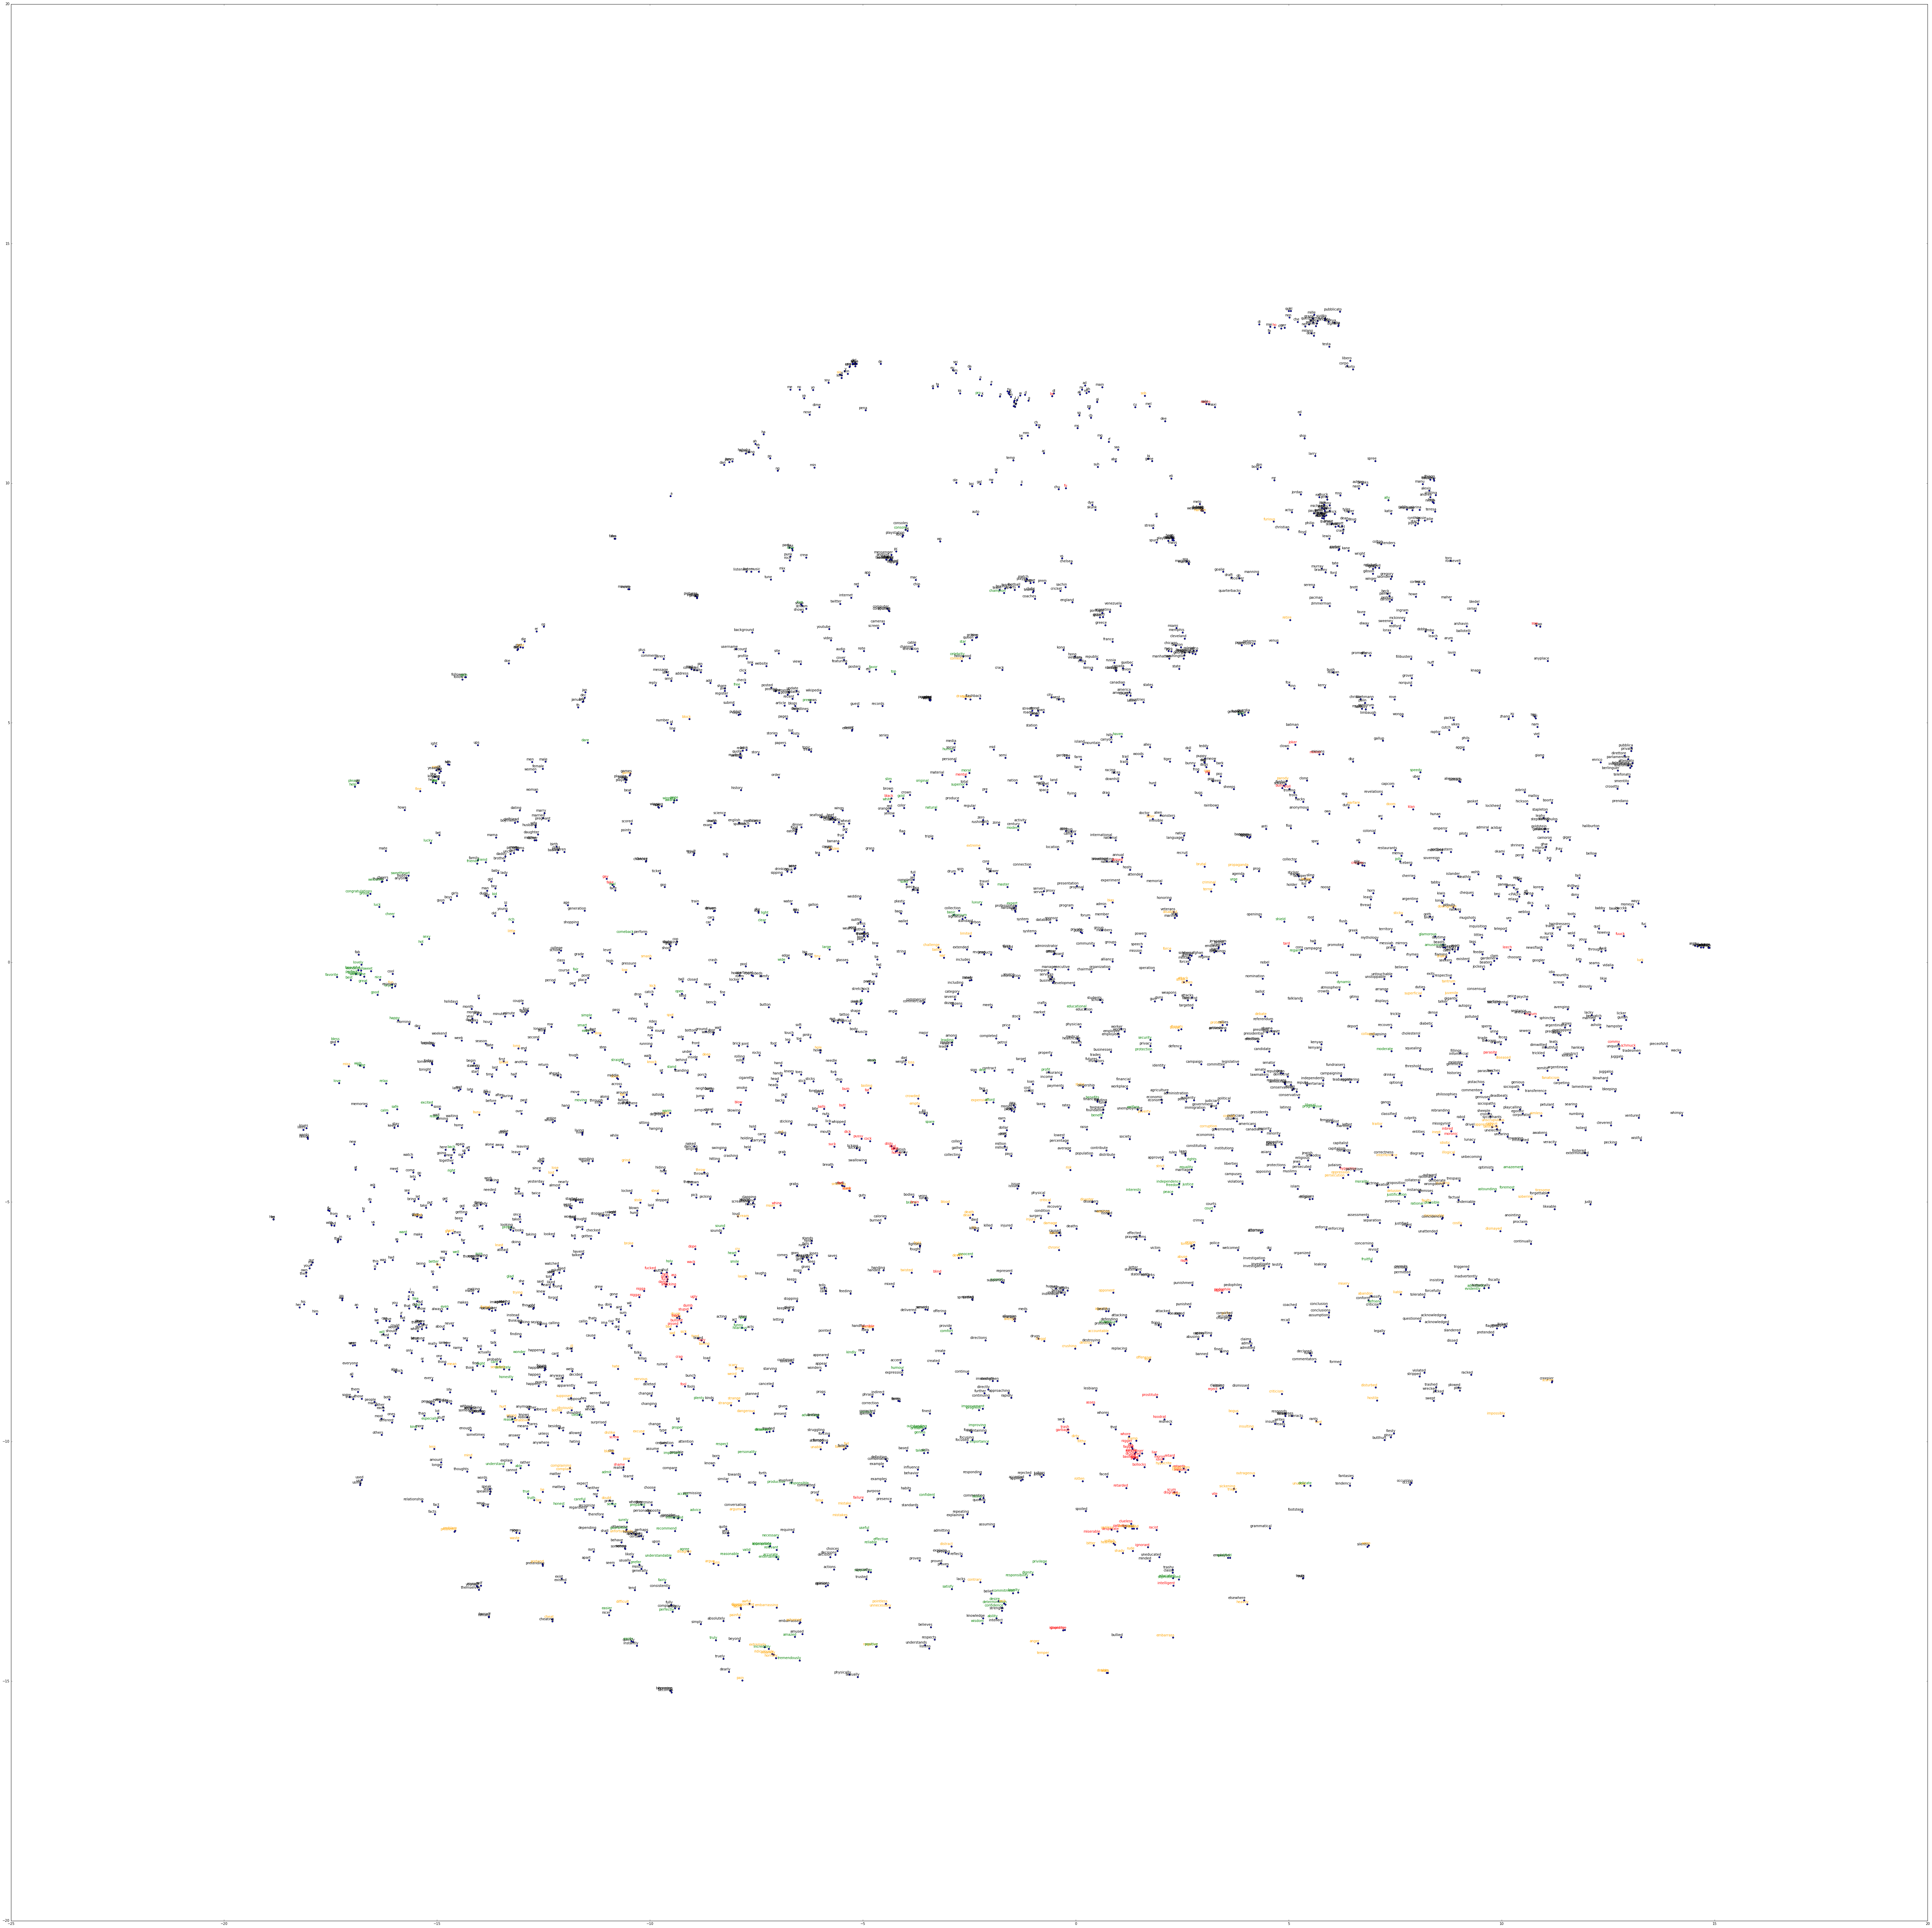

In [73]:
_plot_with_labels(W_TSNE, word_label[:3000], path=None, size=(100, 100))